# ***Build a Seq2Seq Model with Attention***


## Seq2Seq without Attention
![](https://miro.medium.com/max/1400/1*6LolYiXbvsUV4KLkuFlXnA.png)

## Seq2Seq with Attention
![](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

## ***2-Layer LSTM without Attention***

Model: "seq2seq_2_layers"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 18)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12, 27)]     0                                            
__________________________________________________________________________________________________
1st_layer_enc_LSTM (LSTM)       [(None, 4, 256), (No 281600      input_1[0][0]                    
__________________________________________________________________________________________________
1st_layer_dec_LSTM (LSTM)       [(None, 12, 256), (N 290816      input_2[0][0]                    
                                                                 1st_layer_enc_LSTM

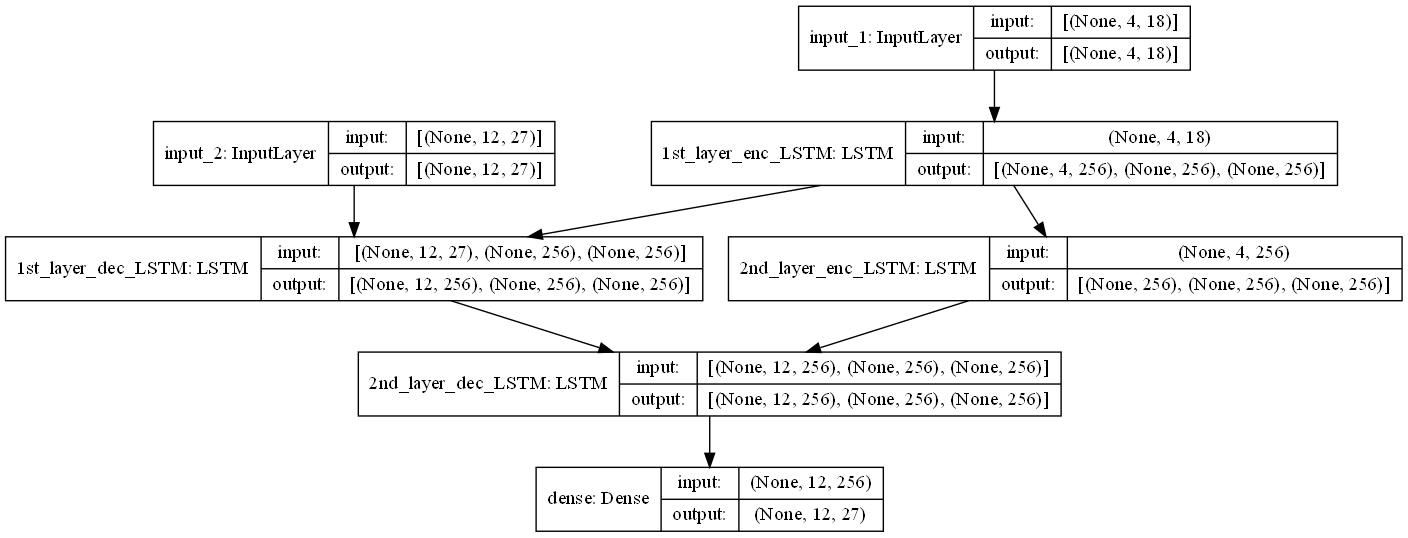

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Model
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
# tf.keras.utils.vis_utils.pydot = pyd


### preparing hyperparameters

## source language- Eng
src_wordEmbed_dim = 18
src_max_seq_length = 4 # max length of a sentence

## target language- Spanish (for example)
tgt_wordEmbed_dim = 27
tgt_max_seq_length = 12 # max length of a sentence

# dimensionality of context vector
latent_dim = 256



# Building a 2-layer LSTM encoder
enc_layer_1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_enc_LSTM")
enc_layer_2 = LSTM(latent_dim, return_sequences = False, return_state = True, name = "2nd_layer_enc_LSTM")
enc_inputs = Input(shape = (src_max_seq_length, src_wordEmbed_dim))
enc_outputs_1, enc_h1, enc_c1 = enc_layer_1(enc_inputs)
enc_outputs_2, enc_h2, enc_c2 = enc_layer_2(enc_outputs_1)
enc_states = [enc_h1, enc_c1, enc_h2, enc_h2]


# Building a 2-layer LSTM decoder
dec_layer_1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_dec_LSTM")
dec_layer_2 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "2nd_layer_dec_LSTM")
dec_dense = Dense(tgt_wordEmbed_dim, activation = "softmax")
dec_inputs = Input(shape = (tgt_max_seq_length, tgt_wordEmbed_dim))
dec_outputs_1, dec_h1, dec_c1 = dec_layer_1(dec_inputs, initial_state = [enc_h1, enc_c1])
dec_outputs_2, dec_h2, dec_c2 = dec_layer_2(dec_outputs_1, initial_state = [enc_h2, enc_c2])
dec_outputs_final = dec_dense(dec_outputs_2)



# Integrate seq2seq model
seq2seq_2_layers = Model([enc_inputs, dec_inputs], dec_outputs_final, name = "seq2seq_2_layers")
seq2seq_2_layers.summary()

plot_model(seq2seq_2_layers, to_file = "output/2-layer_seq2seq.png", dpi = 100, show_shapes = True, show_layer_names = True)

## ***2-Layer LSTM with Attention***

attention weights - shape: (None, 12, 4)
shapes of attenton_weights: (None, 12, 4), enc_outputs_2: (None, 4, 256)
context vector - shape: (None, 12, 256)
ht_context_vec - shape: (None, 12, 512)
attention_vec - shape: (None, 12, 256)
dec_outputs_final - shape: (None, 12, 27)
Model: "seq2seq_2_layers"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 18)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12, 27)]     0                                            
__________________________________________________________________________________________________
1st_layer_enc_LSTM (LSTM)       [(None, 4, 256), (No 281600      input_1[0][0]                    
______

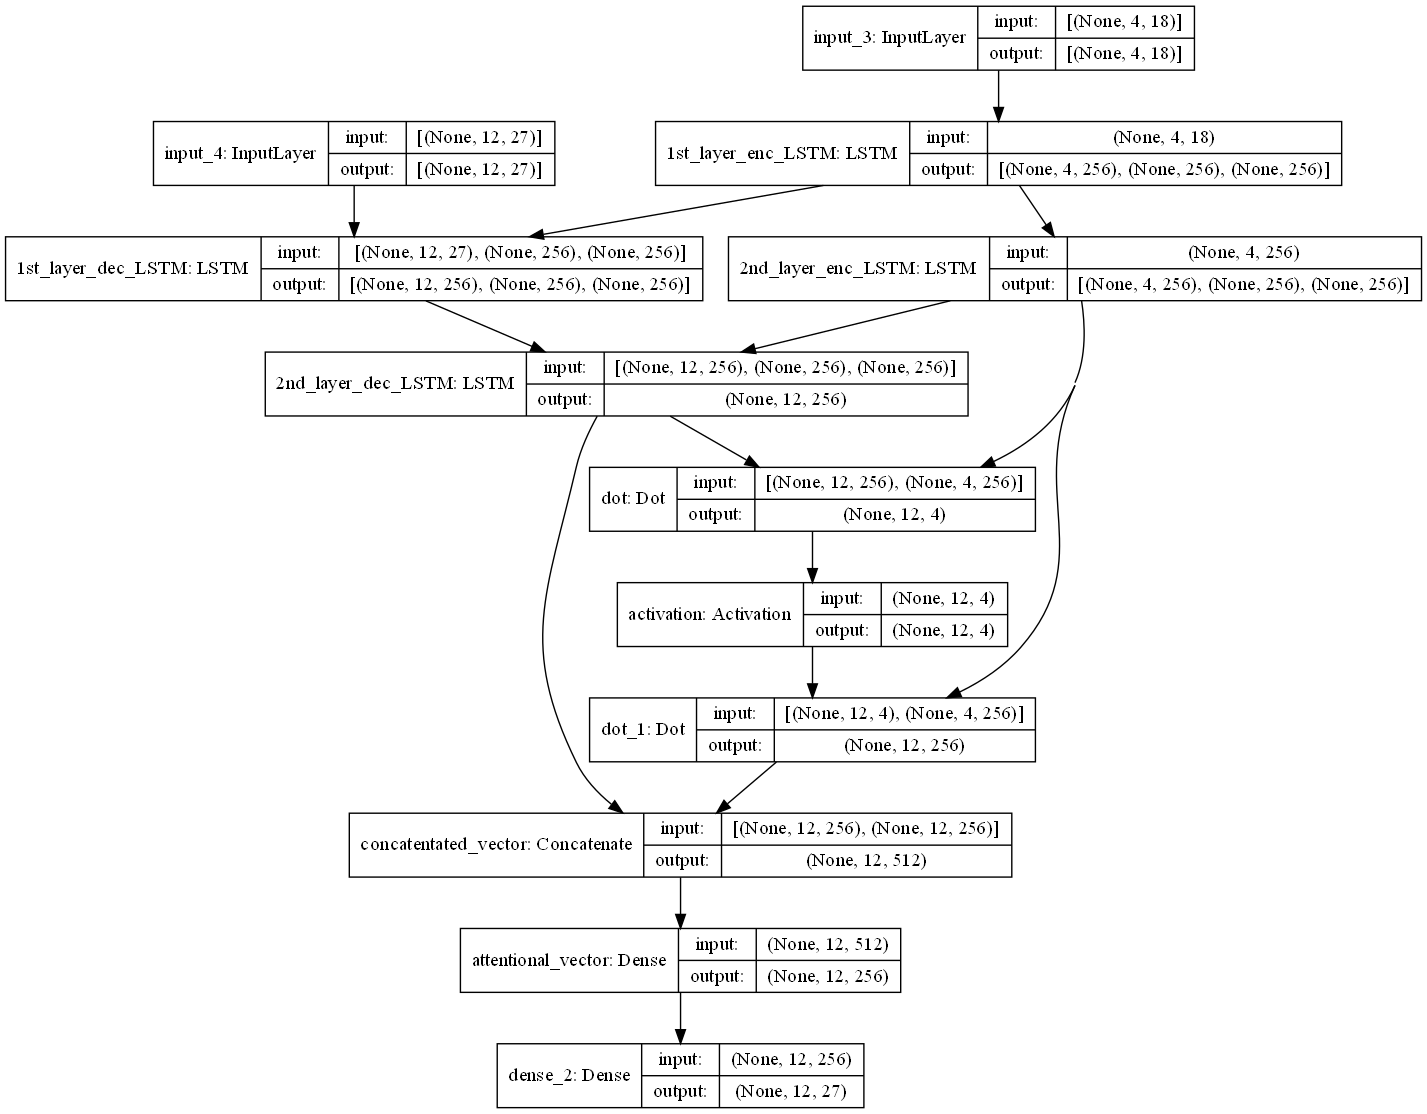

In [2]:
from tensorflow.keras.layers import Activation, dot, concatenate
from tensorflow.keras.activations import tanh
import os

### preparing hyperparameters

## source language- English
src_wordEmbed_dim = 18 # dim of text vector representation
src_max_seq_length = 4 # max length of a sentence (including punctuations)

## target language- Spanish
tgt_wordEmbed_dim = 27 # dim of text vector representation
tgt_max_seq_length = 12 # max length of a sentence (including <SOS> and <EOS>)

# dim of context vector
latent_dim = 256



### Building a 2-layer LSTM encoder
enc_layer_1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_enc_LSTM")
enc_layer_2 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "2nd_layer_enc_LSTM")
enc_inputs = Input(shape = (src_max_seq_length, src_wordEmbed_dim))
enc_outputs_1, enc_h1, enc_c1 = enc_layer_1(enc_inputs)
enc_outputs_2, enc_h2, enc_c2 = enc_layer_2(enc_outputs_1)
enc_states = [enc_h1, enc_c1, enc_h2, enc_h2]


### Building a 2-layer LSTM decoder
dec_layer_1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_dec_LSTM")
dec_layer_2 = LSTM(latent_dim, return_sequences = True, return_state = False, name = "2nd_layer_dec_LSTM")
dec_dense = Dense(tgt_wordEmbed_dim, activation = "softmax")
dec_inputs = Input(shape = (tgt_max_seq_length, tgt_wordEmbed_dim))
dec_outputs_1, dec_h1, dec_c1 = dec_layer_1(dec_inputs, initial_state = [enc_h1, enc_c1])
dec_outputs_2 = dec_layer_2(dec_outputs_1, initial_state = [enc_h2, enc_c2])


### Attention Mechanism
# evaluate attention score
attention_scores = dot([dec_outputs_2, enc_outputs_2], axes = [2, 2])
attenton_weights = Activation("softmax")(attention_scores)
print("attention weights - shape: {}".format(attenton_weights.shape)) # shape: (None, enc_max_seq_length, dec_max_seq_length)
print("shapes of attenton_weights: {}, enc_outputs_2: {}".format(attenton_weights.shape, enc_outputs_2.shape))
os.system("pause")
context_vec = dot([attenton_weights, enc_outputs_2], axes = [2, 1])
print("context vector - shape: {}".format(context_vec.shape)) # shape: (None, dec_max_seq_length, latent_dim)
ht_context_vec = concatenate([context_vec, dec_outputs_2], name = "concatentated_vector")
print("ht_context_vec - shape: {}".format(ht_context_vec.shape)) # shape: (None, dec_max_seq_length, 2 * latent_dim)
attention_vec = Dense(latent_dim, use_bias = False, activation = "tanh", name = "attentional_vector")(ht_context_vec)
print("attention_vec - shape: {}".format(attention_vec.shape)) # shape: (None, dec_max_seq_length, latent_dim)
dec_outputs_final = Dense(tgt_wordEmbed_dim, use_bias = False, activation = "softmax")(attention_vec)
print("dec_outputs_final - shape: {}".format(dec_outputs_final.shape)) # shape: (None, dec_max_seq_length, tgt_wordEmbed_dim)


# Integrate seq2seq model with attention mechanism
seq2seq_2_layers_attention = Model([enc_inputs, dec_inputs], dec_outputs_final, name = "seq2seq_2_layers_attention")
seq2seq_2_layers.summary()

plot_model(seq2seq_2_layers_attention, to_file = "output/2-layer_seq2seq_attention.png", dpi = 100, show_shapes = True, show_layer_names = True)

## ***Using User-Defined Seq2Seq Class***

In [5]:
from seq2seq_lstm import My_Seq2Seq
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input


# preparing data
enc_inputs = Input(shape = (src_max_seq_length, src_wordEmbed_dim))
dec_inputs = Input(shape = (tgt_max_seq_length, tgt_wordEmbed_dim))



### preparing hyperparameters
# source language- English
src_wordEmbed_dim = 18 # dim of text vector representation
src_max_seq_length = 4 # max length of a sentence (including punctuations)

# target language- Spanish
tgt_wordEmbed_dim = 27 # dim of text vector representation
tgt_max_seq_length = 12 # max length of a sentence (including <SOS> and <EOS>)

latent_dim = 256


my_seq2seq_v2 = My_Seq2Seq(latent_dim, src_wordEmbed_dim, src_max_seq_length, tgt_wordEmbed_dim, tgt_max_seq_length, model_name = "seq2seq_no_attention")
dec_outputs = my_seq2seq_v2(
    enc_inputs = Input(shape = (src_max_seq_length, src_wordEmbed_dim)),
    dec_inputs = Input(shape = (tgt_max_seq_length, tgt_wordEmbed_dim)),
    withAttention = False
    )
print("model name: {}".format(my_seq2seq_v2.name))
my_seq2seq_v2.summary()
my_seq2seq_v2.plot_model_arch(enc_inputs, dec_inputs)
# plot_model(my_seq2seq_v2, to_file = "output/seq2seq_LSTM_without_attention.png", dpi = 100, show_shapes = True, show_layer_names = True)



outputs_final - shape: (None, 12, 27)
model name: seq2seq_no_attention
Model: "seq2seq_no_attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_3 (Encoder)          ((None, 256), [(None, 256 806912    
_________________________________________________________________
decoder_3 (Decoder)          (None, 12, 27)            1348379   
Total params: 2,155,291
Trainable params: 2,155,291
Non-trainable params: 0
_________________________________________________________________


TypeError: call() missing 1 required positional argument: 'dec_inputs'

In [6]:
import numpy as np
import os
print(os.getcwd())

from preprocessing import num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model

encoder_input_data = np.load("data/encoder_inputs.npy")
decoder_input_data = np.load("data/decoder_inputs.npy")
decoder_target_data = np.load("data/decoder_targets.npy")
latent_dim = 256

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
x = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
x, state_h, state_c = LSTM(latent_dim,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
x = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
x = LSTM(latent_dim, return_sequences=True)(x, initial_state=encoder_states)
decoder_outputs = Dense(num_decoder_tokens, activation='softmax')(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size = 11,
          epochs = 100,
          validation_split = 0.2)

E:\IT_Iron_Man_Challenge\Machine Translation\seq2seq_translator
Epoch 1/100


ValueError: in user code:

    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:663 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Friedrich Cheng\miniconda3\envs\Py38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer lstm is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 4, 18, 256]
